<a href="https://colab.research.google.com/github/dmf49/CSEE5590/blob/main/DP_TF_MultiText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-privacy==0.1.0


In [2]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

from absl import app
from absl import flags
from absl import logging


import tensorflow as tf
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.metrics import log_loss, accuracy_score

2.8.0


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
STOPWORDS = set(stopwords.words('english'))

import pandas as pd
from sklearn import preprocessing


from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

In [5]:
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
AdamOptimizer = tf.compat.v1.train.AdamOptimizer

flags.DEFINE_boolean(
    'dpsgd', True, 'If True, train with DP-SGD. If False, '
    'train with vanilla SGD.')
flags.DEFINE_float('learning_rate', 0.005, 'Learning rate for training')
flags.DEFINE_float('noise_multiplier', 1.1,
                   'Ratio of the standard deviation to the clipping norm')
flags.DEFINE_float('l2_norm_clip', 1.0, 'Clipping norm')
flags.DEFINE_integer('batch_size', 250, 'Batch size')
flags.DEFINE_integer('epochs', 60, 'Number of epochs')
flags.DEFINE_integer(
    'microbatches', 250, 'Number of microbatches '
    '(must evenly divide batch_size)')
flags.DEFINE_string('model_dir', None, 'Model directory')

FLAGS = flags.FLAGS

embedding_dim = 100
max_length = 2000

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()



def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = 250 / 60000
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=1.1,
                    steps=steps,
                    orders=orders)

  # Delta is set to 1e-5 because product_reviews has 70000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv("/content/drive/MyDrive/project_mod/rows.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
print(df.head(2))

    # Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

    # Renaming second column
df1.columns = ['Product', 'Consumer_complaint']

    # Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total / len(df) * 100), 1)

print(pd.DataFrame(df.Product.unique()).values)

df2 = df1.sample(10000, random_state=1).copy()

  Date received                      Product  \
0    05/10/2019  Checking or savings account   
1    05/10/2019  Checking or savings account   

                        Sub-product                Issue  \
0                  Checking account  Managing an account   
1  Other banking product or service  Managing an account   

                           Sub-issue Consumer complaint narrative  \
0  Problem using a debit or ATM card                          NaN   
1           Deposits and withdrawals                          NaN   

  Company public response                        Company State ZIP code  \
0                     NaN      NAVY FEDERAL CREDIT UNION    FL    328XX   
1                     NaN  BOEING EMPLOYEES CREDIT UNION    WA    98204   

             Tags Consumer consent provided? Submitted via  \
0  Older American                        NaN           Web   
1             NaN                        NaN      Referral   

  Date sent to company Company response to consumer T

In [10]:
# Renaming categories
df2.replace({'Product':
                     {'Credit reporting, credit repair services, or other personal consumer reports':
                          'CreditReporting',
                      'Credit reporting': 'CreditReporting',
                      'Credit card': 'CreditPrepaidCard',
                      'Prepaid card': 'CreditPrepaidCard',
                      'Credit card or prepaid card': 'CreditPrepaidCard',
                      'Payday loan': 'PersonalLoan',
                      'Payday loan, title loan, or personal loan' : 'PersonalLoan',
                      'Money transfer': 'TransferServices',
                      'Virtual currency': 'TransferServices',
                      'Money transfer, virtual currency, or money service' : 'TransferServices',
                      'Student loan': 'StudentLoan',
                      'Checking or savings account': 'SavingsAccount',
                      'Vehicle loan or lease': 'VehicleLoan',
                      'Debt collection': 'DebtCollection',
                      'Bank account or service' : 'BankAccount',
                      'Other financial service': 'FinancialServices',
                      'Consumer Loan': 'ConsumerLoan',
                      'Money transfers': 'MoneyTransfers'}},
                inplace=True)

                    0
0     CreditReporting
1      DebtCollection
2        ConsumerLoan
3   CreditPrepaidCard
4            Mortgage
5         VehicleLoan
6         StudentLoan
7        PersonalLoan
8      SavingsAccount
9         BankAccount
10   TransferServices
11     MoneyTransfers
12  FinancialServices
                  Product                                 Consumer_complaint  \
310399    CreditReporting  Bayview completely ignored laws and is reporti...   
186155    CreditReporting  inaccurate information no knowledge of account...   
651135     DebtCollection  On XXXX/XXXX/2016 I received a notice from Con...   
515233       ConsumerLoan  I have a loan with  Kia Motor Finance. I  rece...   
641112  CreditPrepaidCard  I have a XXXX BIG card and made my payment whe...   

        category_id  
310399            3  
186155            3  
651135            4  
515233            1  
641112            2  


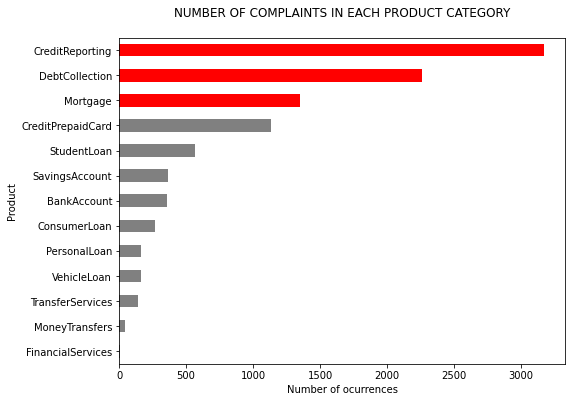

Length of labels10000
Length of product_comments10000


In [11]:
print(pd.DataFrame(df2.Product.unique()))

    # Create a new column 'category_id' with label-encoded categories
le = preprocessing.LabelEncoder()
df2['category_id'] = le.fit_transform(df2['Product'])

category_id_df = df2[['Product', 'category_id']].drop_duplicates()
print(df2.head())

fig = plt.figure(figsize=(8, 6))
colors = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey',
              'grey', 'red', 'red', 'red']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
        ylim=0, color=colors, title='NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize=10)
plt.show()

product_comments = df2['Consumer_complaint'].values  # Collection of documents
product_type = df2['category_id'].values # Target or the labels we want to predict (i.e., the 13 different complaints of products)

print("Length of labels" + str(len(product_type)))
print("Length of product_comments" + str(len(product_comments)))

In [12]:
complains = []
labels = []
for i in range(0, len(product_comments)): 
  complain = product_comments[i]
  labels.append(product_type[i])
  complain = complain.replace('XX', '')
  complain = complain.replace('.', '')
  for word in STOPWORDS:
    token = ' ' + word + ' '
    complain = complain.replace(token, ' ')
    complain = complain.replace(' ', ' ')
    complains.append(complain)

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(complains)

word_index = tokenizer.word_index
vocab_size = len(word_index)
sequences = tokenizer.texts_to_sequences(product_comments)
padded = pad_sequences(sequences, maxlen=max_length)
train_size = int(len(product_comments) * 0.7)
validation_size = int(len(product_comments) * 0.2)

training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:train_size+validation_size]
validation_labels = labels[train_size:train_size+validation_size]

test_sequences = padded[train_size + validation_size:]
test_labels = labels[train_size + validation_size:]

training_label_seq = np.reshape(np.array(train_labels), (len(train_labels), 1))
validation_label_seq = np.reshape(np.array(validation_labels), (len(validation_labels), 1))
test_label_seq = np.reshape(np.array(test_labels), (len(test_labels), 1))

print(training_label_seq.shape)
print(validation_label_seq.shape)
print(test_label_seq.shape)

print(training_sequences.shape)
print(validation_sequences.shape)
print(test_sequences.shape)

print(vocab_size)
print(word_index['i'])

(7000, 1)
(2000, 1)
(1000, 1)
(7000, 2000)
(2000, 2000)
(1000, 2000)
20815
1


In [14]:
embeddings_index = {};
with open('/content/drive/MyDrive/project_mod/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split();
    word = values[0];
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector

print(len(embeddings_matrix))

20816


In [15]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix],
                                  trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(13, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         2081600   
                                                                 
 dropout (Dropout)           (None, 2000, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, 1996, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 13)                845       
                                                        

In [16]:
from absl import logging
import collections

from privacy.analysis import privacy_ledger
from privacy.dp_query import gaussian_query

def make_optimizer_class(cls):
    """Constructs a DP optimizer class from an existing one."""
    parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
    child_code = cls.compute_gradients.__code__
    GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP  # pylint: disable=invalid-name
    if child_code is not parent_code:
         logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

    class DPOptimizerClass(cls):
        """Differentially private subclass of given class cls."""
        _GlobalState = collections.namedtuple('_GlobalState', ['l2_norm_clip', 'stddev'])
    
        def __init__(self, dp_sum_query, num_microbatches=None, unroll_microbatches=False, *args,  # pylint: disable=keyword-arg-before-vararg, g-doc-args
                     **kwargs):
            """Initialize the DPOptimizerClass.
            Args:
        dp_sum_query: DPQuery object, specifying differential privacy mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
            """
            super(DPOptimizerClass, self).__init__(*args, **kwargs)
            self._dp_sum_query = dp_sum_query
            self._num_microbatches = num_microbatches
            self._global_state = self._dp_sum_query.initial_global_state()
            # TODO(b/122613513): Set unroll_microbatches=True to avoid this bug.
            # Beware: When num_microbatches is large (>100), enabling this parameter
            # may cause an OOM error.
            self._unroll_microbatches = unroll_microbatches

        def compute_gradients(self, loss, var_list, gate_gradients=GATE_OP,
                          aggregation_method=None, colocate_gradients_with_ops=False,
                          grad_loss=None, gradient_tape=None, curr_noise_mult=0, curr_norm_clip=1):
            self._dp_sum_query = gaussian_query.GaussianSumQuery(curr_norm_clip, 
                                                           curr_norm_clip*curr_noise_mult)
            self._global_state = self._dp_sum_query.make_global_state(curr_norm_clip, 
                                                                curr_norm_clip*curr_noise_mult)
            # TF is running in Eager mode, check we received a vanilla tape.
            if not gradient_tape:
                raise ValueError('When in Eager mode, a tape needs to be passed.')
            vector_loss = loss()
            if self._num_microbatches is None:
                self._num_microbatches = tf.shape(input=vector_loss)[0]
            sample_state = self._dp_sum_query.initial_sample_state(var_list)
            microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
            sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

            def process_microbatch(i, sample_state):
                """Process one microbatch (record) with privacy helper."""
                microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
                grads = gradient_tape.gradient(microbatch_loss, var_list)
                sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
                return sample_state
    
            for idx in range(self._num_microbatches):
                sample_state = process_microbatch(idx, sample_state)

            if curr_noise_mult > 0:
                grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
            else:
                grad_sums = sample_state

            def normalize(v):
                return v / tf.cast(self._num_microbatches, tf.float32)

            final_grads = tf.nest.map_structure(normalize, grad_sums)
            grads_and_vars = final_grads #list(zip(final_grads, var_list))
    
            return grads_and_vars

    return DPOptimizerClass

def make_gaussian_optimizer_class(cls):
    """Constructs a DP optimizer with Gaussian averaging of updates."""

    class DPGaussianOptimizerClass(make_optimizer_class(cls)):
        """DP subclass of given class cls using Gaussian averaging."""

        def __init__(self, l2_norm_clip, noise_multiplier, num_microbatches=None,
        ledger=None, unroll_microbatches=False,*args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
            dp_sum_query = gaussian_query.GaussianSumQuery(l2_norm_clip, l2_norm_clip * noise_multiplier)

            if ledger:
              dp_sum_query = privacy_ledger.QueryWithLedger(dp_sum_query,ledger=ledger)

            super(DPGaussianOptimizerClass, self).__init__(dp_sum_query, num_microbatches, unroll_microbatches,
                  *args, **kwargs)

        @property
        def ledger(self):
            return self._dp_sum_query.ledger

    return DPGaussianOptimizerClass

In [17]:
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
DPGradientDescentGaussianOptimizer_NEW = make_gaussian_optimizer_class(GradientDescentOptimizer)

optimizer = DPGradientDescentGaussianOptimizer_NEW(
        l2_norm_clip=1.0,
        noise_multiplier=1.1,
        num_microbatches=25,
        learning_rate=0.005)


model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         2081600   
                                                                 
 dropout (Dropout)           (None, 2000, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, 1996, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 13)                845       
                                                        

Epoch 1/10
219/219 - 145s - loss: 2.0413 - accuracy: 0.3191 - val_loss: 1.9754 - val_accuracy: 0.3160 - 145s/epoch - 661ms/step
Epoch 2/10
219/219 - 141s - loss: 1.9444 - accuracy: 0.3199 - val_loss: 1.9325 - val_accuracy: 0.3165 - 141s/epoch - 644ms/step
Epoch 3/10
219/219 - 141s - loss: 1.9023 - accuracy: 0.3244 - val_loss: 1.8792 - val_accuracy: 0.3170 - 141s/epoch - 643ms/step
Epoch 4/10
219/219 - 141s - loss: 1.8801 - accuracy: 0.3301 - val_loss: 1.9083 - val_accuracy: 0.3505 - 141s/epoch - 645ms/step
Epoch 5/10
219/219 - 143s - loss: 1.8526 - accuracy: 0.3416 - val_loss: 1.8718 - val_accuracy: 0.3615 - 143s/epoch - 655ms/step
Epoch 6/10
219/219 - 147s - loss: 1.8725 - accuracy: 0.3326 - val_loss: 1.8716 - val_accuracy: 0.3465 - 147s/epoch - 670ms/step
Epoch 7/10
219/219 - 145s - loss: 1.8460 - accuracy: 0.3451 - val_loss: 1.7797 - val_accuracy: 0.3475 - 145s/epoch - 662ms/step
Epoch 8/10
219/219 - 143s - loss: 1.8813 - accuracy: 0.3316 - val_loss: 1.8773 - val_accuracy: 0.3580 - 

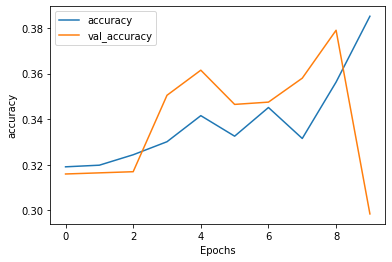

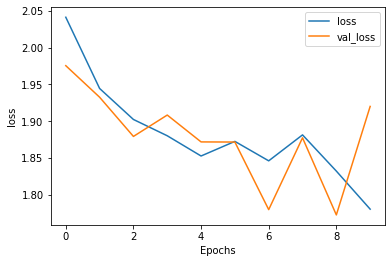

Accuracy: 29.80%
(1000, 13)
(1000,)
(1000, 1)
(1000, 1)
[[  0   0   2   1   3   0   0  29   0   0   0   0   0]
 [  0   0   0   2   4   0   0  31   0   0   0   0   0]
 [  0   0   2   0  25   0   0  84   0   0   0   0   0]
 [  0   0   6  67 143   0   0  85   0   0   0   0   0]
 [  0   0   4  18  95   0   0  87   0   0   0   0   0]
 [  0   0   0   0   1   0   0   1   0   0   0   0   0]
 [  0   0   1   0   3   0   0   3   0   0   0   0   0]
 [  0   0   2   6  20   0   0 134   0   0   0   0   0]
 [  0   0   1   0   6   0   0  11   0   0   0   0   0]
 [  0   0   0   2   7   0   0  28   0   0   0   0   0]
 [  0   0   1   3   8   0   0  48   0   0   0   0   0]
 [  0   0   0   0   3   0   0   5   0   0   0   0   0]
 [  0   0   1   2   5   0   0  10   0   0   0   0   0]]


In [18]:
num_epochs = 10

history = model.fit(training_sequences, training_label_seq, epochs=num_epochs,validation_data=(validation_sequences, validation_label_seq), verbose=2)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

scores = model.evaluate(test_sequences, test_label_seq, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

output_test = model.predict(test_sequences)
print(np.shape(output_test))
final_pred = np.argmax(output_test, axis=1)
print(np.shape(final_pred))
print(np.shape(test_label_seq))
final_pred_list = np.reshape(final_pred, (len(test_sequences), 1))
print(np.shape(final_pred_list))

results = confusion_matrix(test_label_seq, final_pred_list)
print(results)

In [20]:
eps = compute_epsilon(60 * 60000 // 250)
print('For delta=1e-5, the  epsilon is: %.2f' % eps)


For delta=1e-5, the  epsilon is: 2.97
